

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#from time import time
import time
import json
import sys
import os
import random

# matplotlib and PIL imports
import numpy as np
import matplotlib.pyplot as plt        # (load and display images)

from PIL import Image
from collections import OrderedDict    #storing state_dict - all the weights and parameter

# General pytorch imports:
import torch                           # root package
print("pytorch", torch.__version__)    # print the current version of pytorch
from torch.utils.data import Dataset   # dataset representation and loading

# Neural Network API imports
import torch.autograd as autograd     # computation graph
from torch.autograd import Variable    # variable node in computation graph               
from torch import nn                   # neural networks
import torch.nn.functional as F        # layers, activations and more, to use nn functions to # define your layers
from torch import optim                # optimizers e.g. gradient descent, ADAM, etc.
# from torch.optim import lr_scheduler

# pytorch vision imports
import torchvision                     #enables use of CNN neural nets, ResNet VGG and other pretrained models
from torchvision import datasets, models, transforms     # vision datasets, architectures & transforms 
from torchvision.utils import make_grid

#import train
#import predict
# import pdb

pytorch 0.4.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
#def def_data_dirs(data_dir): 
#The images have large scale, pose and light variations. 
#In addition, there are categories that have large variations within the category and several very similar categories. 
#The dataset is visualized using isomap with shape and colour features.

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = 'flowers'
# sub directories
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# get a filename from the data directory
# reference:  https://stackoverflow.com/questions/31346593/how-to-list-all-directories-that-do-not-contain-a-file-type
import os

def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths 

def pick_random_flower():
    # generate random integer
    ridx = random.randint(0,102)  #102 is the number of different classes of flowers
    return ridx

def get_randomimage(ridx, data_directory):
    # take the random number and data dir & index into it randomly, output the image_path (filename) of a flower in the test dir
    get_filepaths(data_directory)
    full_file_paths = get_filepaths(data_directory)
    image_path = full_file_paths[ridx]
    return image_path

ridx = pick_random_flower()
image_path = get_randomimage(ridx, test_dir)
print("Random selection is: \t")
print(image_path)        

Random selection is: 	
flowers/test/19/image_06170.jpg


In [5]:
# Check for gpu or cuda, then set parameters, and provide info
# reference:  https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
print("GPU {}".format("Enabled" if torch.cuda.is_available() else "Disabled"))
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
         
#Additional Info when using cuda
if device.type == 'cuda':
    print("{}  {}:  {}{}{}{}{}{}".format(torch.cuda.get_device_name(0),
    '  Memory Usage-->','Allocated: ',1024,' GB',' Cached: ',round(torch.cuda.memory_cached(0)/1024**3,1),' GB'))

device: cuda
GPU Enabled
Tesla K80    Memory Usage-->:  Allocated: 1024 GB Cached: 0.0 GB


In [6]:
# Define your transforms for the training, validation, and testing sets
# def load_and_transform(data_dir):
# Data augmentation and normalization for training
# Just normalization for validation
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

norm_mean = [0.485, 0.456, 0.406]
norm_std  = [0.229, 0.224, 0.225]
data_transforms = {
# For the training, you'll want to apply transformations such as random scaling, cropping, and flipping
# The validation and testing sets are used to measure the model's performance on data it hasn't seen yet.
# For this you don't want any scaling or rotation transformations, 
# but you'll need to resize then crop the images to the appropriate size.
# training - Normalized training data loader with random crops, flipping and resizing applied
# validation - Normalized validation data loader with fixed cropping and resizing
# testing - Normalized testing data loader with fixed cropping and resizing
'training_transforms' :    transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
'validation_transforms' :  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
'testing_transforms'     :  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
}
print("transformations completed")

transformations completed


In [7]:
#    Creates pytorch training, validation and testing pytorch dataloaders and applies transformations
#    respectively, and then through our network for training, testing and prediction. Uses ImageFolder and Dataloader 
#    Parameters:
#        data_dir - Path to data to be used
#    Returns:
#        training - Normalized training data loader with random crops, flipping and resizing applied
#        testing - Normalized testing data loader with fixed cropping and resizing
#        validation - Normalized validation data loader with fixed cropping and resizing

# Load the datasets with ImageFolder
print("Initializing Datasets and Dataloaders...")
# Create training, validation, and testing datasets
# Load the datasets with ImageFolder - make sure data is in flowers folder. 
image_datasets = {
    'training_dataset'    : datasets.ImageFolder(train_dir, transform=data_transforms['training_transforms']),
    'validation_dataset'  : datasets.ImageFolder(valid_dir, transform=data_transforms['validation_transforms']),
    'testing_dataset'     : datasets.ImageFolder(test_dir,  transform=data_transforms['testing_transforms'])
}
#  Using the image datasets and the trainforms, define the dataloaders

# Batch size for training, (change depending on how much memory you have) 
batch_size = 64
# The training, validation, testing returns images and labels(labels are the class that the image belongs to)
dataloaders = {
    'training'    : torch.utils.data.DataLoader(image_datasets['training_dataset'], batch_size, shuffle=True ),
    'validation'  : torch.utils.data.DataLoader(image_datasets['validation_dataset'], batch_size, shuffle=True ),
    'testing'     : torch.utils.data.DataLoader(image_datasets['testing_dataset'], batch_size )
}
trainloader      = dataloaders['training']
vloader          = dataloaders['validation']
testloader       = dataloaders['testing']

dataset_sizes = {x: len(image_datasets[x]) for x in ['training_dataset', 'validation_dataset', 'testing_dataset']}
print ("sizes:", dataset_sizes, 'batch_size:', batch_size)

# Get the class ids and Store class_to_idx into a model property
class_to_idx = image_datasets['training_dataset'].classes
# class_to_idx = image_datasets['training_dataset'].class_to_idx

print("class ids as a list: ", class_to_idx)

output_size = len(class_to_idx)
print("Number of classes: ", output_size)

#  return dataloaders, trainloader, vloader, testloader, class_to_idx, dataset_sizes

Initializing Datasets and Dataloaders...
sizes: {'training_dataset': 6552, 'validation_dataset': 818, 'testing_dataset': 819} batch_size: 64
class ids as a list:  ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Number of classes:  102


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
# create a mapping from the label number (some number between 1 and 102) and the actual flower name. 
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# class_to_idx = list(cat_to_name.values())
print(class_to_idx)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [9]:
# Explore the current batch, ids and labels
print("Now show only data batch tensor, ids, and labels")
inputs, labels = next(iter(dataloaders['training']))
print("batch_size", batch_size)
#inputs, labels = next(iter(trainloader))
print(inputs.size())   # gets the batch tensor info
print(labels)

rand_idx = np.random.randint(len(inputs))
# print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),class_to_idx[labels[rand_idx].item()], cat_to_name[class_to_idx[labels[rand_idx].item()]]))


Now show only data batch tensor, ids, and labels
batch_size 64
torch.Size([64, 3, 224, 224])
tensor([  22,   60,   83,   24,   72,   30,  100,   92,   75,   29,
          89,    4,   80,   48,   76,   13,   49,   53,   74,   25,
          73,   52,   43,   89,   70,   90,   87,   54,   33,    5,
          63,   77,   63,   44,    4,   29,   59,   63,   65,   79,
          49,   84,   30,   67,   57,   97,   97,   73,   86,   73,
          85,   77,   44,   52,   77,    2,   63,   34,   10,   27,
          14,   56,   87,   28])
label: 89, class: 88, name: cyclamen


Visualize a few images

batch size: 64
torch.Size([64, 3, 224, 224])
['primula', 'mexican petunia', 'windflower', 'pincushion flower', 'osteospermum', 'stemless gentian', 'giant white arum lily', 'peruvian lily', 'moon orchid', 'passion flower', 'lenten rose', 'english marigold', 'primula', 'pelargonium', 'silverbush', 'foxglove', 'azalea', 'columbine', 'watercress', 'ruby-lipped cattleya', 'red ginger', 'camellia', 'hibiscus', 'tree mallow', 'sunflower', 'daffodil', 'desert-rose', 'bishop of llandaff', 'pink-yellow dahlia', 'gaura', 'frangipani', 'windflower', 'anthurium', 'bromelia', 'bishop of llandaff', 'primula', 'rose', 'camellia', 'pink-yellow dahlia', 'tree mallow', 'bougainvillea', 'azalea', 'sword lily', 'osteospermum', 'clematis', 'pink primrose', 'bromelia', 'oxeye daisy', 'trumpet creeper', 'gaura', 'sweet william', 'morning glory', 'sunflower', 'sunflower', 'morning glory', 'gaura', 'pincushion flower', 'monkshood', 'oxeye daisy', 'mallow', 'hard-leaved pocket orchid', 'cape flower', 'ball moss'

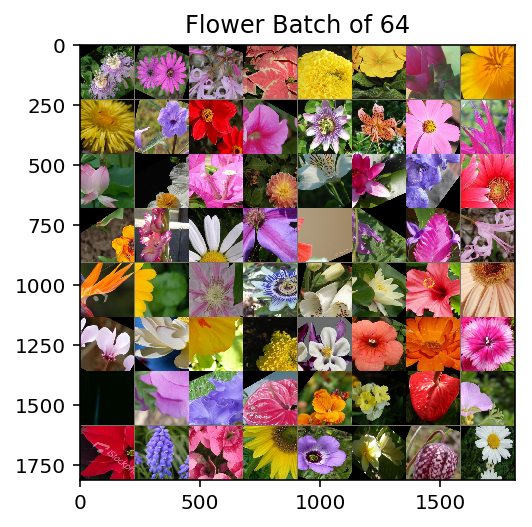

GroundTruth:  primula mexican petunia windflower pincushion flower osteospermum stemless gentian giant white arum lily peruvian lily moon orchid passion flower lenten rose english marigold primula pelargonium silverbush foxglove azalea columbine watercress ruby-lipped cattleya red ginger camellia hibiscus tree mallow sunflower daffodil desert-rose bishop of llandaff pink-yellow dahlia gaura frangipani windflower anthurium bromelia bishop of llandaff primula  rose camellia pink-yellow dahlia tree mallow bougainvillea azalea sword lily osteospermum clematis pink primrose bromelia oxeye daisy trumpet creeper gaura sweet william morning glory sunflower sunflower morning glory gaura pincushion flower monkshood oxeye daisy mallow hard-leaved pocket orchid cape flower ball moss desert-rose


In [10]:
def imshow_batch(inp, title='Flower Batch of ' + str(batch_size)):
    # ref:  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.pause(0.004)  # pause a bit so that plots are updated
    return

# Get a batch of training data
# The dataloader['training']  or trainloader returns images and labels(labels are the class that the image belongs to)
inputs, labels = next(iter(trainloader))  
print("batch size:", batch_size)
print(inputs.size())   # gets the batch size
plt.imshow(inputs[0,1])

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, padding=5)
# assign class names index(s)
class_to_idx = list(cat_to_name.values())
print([class_to_idx[x] for x in labels])

# classes = list(cat_to_name.values())
# print([classes[x] for x in labels])
# print(classes)

print("Now Show the images in the batches", batch_size)
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
imshow_batch(torchvision.utils.make_grid(inputs))
# print all the labels in only the current batch of the dataset 
print('GroundTruth: ', ' '.join('%5s' % class_to_idx[labels[x]] for x in range(batch_size)))

# print(labels)   # prints all the labels in the dataset batch as a tensor

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [11]:
# Build and train your network
# https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
# Transfer learning will be performaed in this project, so I will load a pre-trained model from PyTorch. 
# There are two parts of the classifier that must be consistent

#  The number of input features on line (0) with a value of 25088 must also be the same as our first input layer.
#  The number of output features in line (6) , which is currently 1000 features, 
#  must equal the number of classes we have in our dataset. In our case, we will want to predict the 102 flower classes.
# get command line arguments if required, if you use no argments, then all defaults will be used.

In [12]:
# get_model
# Reference:  https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Downloads and returns model provided. Returns model architecture for the CNN and the associated input_size.
def get_model(arch):
    # Initialize the variables, for which are model specific, they are from the torchvision library
    # the models are pre-trained models from the ImageNet Challenge
    # https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge
    #Parameters:
    #   arch - Used to select which architecture to use for prepare
    # Returns:
    #    model[arch] - selects the variable out of a dictionary and returns the
    #         model associated with arch
    #    input_size[arch] - selects the associated input size for the model selected  
    # for example:
    #     model_select = vgg16 = models.vgg16(pretrained=True)    # input_size = in_features=25088

    vgg16=''
    vgg19=''
    alexnet=''
    densenet161=''
    densenet121=''
    if arch == 'vgg16':
        vgg16 = models.vgg16(pretrained=True)
    elif arch == 'vgg19':
        vgg19 = models.vgg19(pretrained=True)
    elif arch == 'alexnet':
        alexnet = models.alexnet(pretrained=True)
    elif arch == 'densenet121':
        densenet121 = models.densenet121(pretrained=True)
    elif arch == 'densenet161':
        densenet161 = models.densenet161(pretrained=True)
    else:
        print('{} architecture not recognized..use vgg16 / 19, alexnet, densenet121 / 161', format(arch))
        exit()
        
    model_select = {
          "vgg16":vgg16,
          "vgg19":vgg19,
          "alexnet":alexnet,
          "densenet161":densenet161,
          "densenet121":densenet121
     } 
    input_size = {
          "vgg16":25088,
          "vgg19":25088,
          "alexnet":9216,
          "densenet161":2208,
          "densenet121":1024
     }
    return model_select[arch], input_size[arch]

In [13]:
# Build the network, Create classifier
def create_classifier(model, input_size, hidden_layers, output_size, learning_rate, dropout=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # make a device switch, added for cli application 
    print(device)
    """
    Takes a pretrained CNN, freezes the features and creates a untrained classifier. Returns
    model with an untrained classifier, loss function critierion (NLLLoss) and Adam optimizer.
    Parameters:
        model - Pretrained CNN, i'm going to use vgg19 as a default
        input_size -    integer, size of the input layer
        hidden_layers - list of hidden_layer sizes, get via indexing
        output_size -   integer, size of the output layer
        learning_rate (lr) - determines the learning rate for the optimizer
        dropout - determines the dropout probability for the classifier(default- 0.5)
    Returns:
        model - Pretrained feature CNN with untrained classifier  # should change this to classifier instead of model
        criterion - loss function to train on (torch.nn.NLLLoss())
        optimizer - optimizer for new, untrained classifier (torch.optim.Adam)
        schedular - decay adj the lr at (n)step size epochs (optional)
    """
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():  # To use an existing model is equivalent to freeze some 
        param.requires_grad = False   # of its layers and parameters and not train those. 

    #classifier_input_size = model.classifier.in_features  
    print("Input size: ",  input_size)
    print("hidden layers", hidden_layers)                  
    print("output_size",   output_size)    # = number of classes = 102 for flower data
    print("dropout", dropout)

    classifier = nn.Sequential(OrderedDict([
             ('fc1', nn.Linear(input_size,  hidden_layers[0])), # fully connected layer,( "size" - in_features, out_features, bias)
             ('relu', nn.ReLU()),                                 # the activation layer
             ('dropout',nn.Dropout(dropout)),
             ('fc2', nn.Linear( hidden_layers[1], output_size)),
             ('output', nn.LogSoftmax(dim=1))
             ])) 
        
    #Apply new classifier and generate criterion and optimizer    
    model.classifier = classifier   # Now replace the classifier portion of the model
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # Save class to index mapping
    model.class_to_idx = class_to_idx   
    model = model.to(device)              # send model to device
    
    return model , criterion, optimizer


In [14]:
# ref udacity class Inf & Validation video, at 9-11m 
# ref https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test/52178638
# Function to do Test Valication and get test loss and accuracy
def validation(model, criterion, data_loader):
    print(" Now validating mode, getting validation_loss, accuracy")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # make a device switch, added for cli application
    model.to(device)
    model.eval()    # Set model to evaluate mode,  turns dropout off, we don't want it on while doing validation
    
    validation_loss = 0
    validation_accuracy = 0 
    for inputs, labels in data_loader:  # Iterate over validation data(via data_loader)
        if torch.cuda.is_available():
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()     
        else: 
            inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        validation_loss += criterion(output, labels).item()   # this is validation loss, per  

        # print('validation_loss',validation_loss, 'validation_accuracy', validation_accuracy)
        # get the probablities, by taking the exponential
        ps = torch.exp(output)              
        ps.max(dim=1)   #  #tells us the predicted classes by probablity (0-1) second tensor tells use which classes
                        # have the highest probablites within the softmax output

        equality = (labels.data == ps.max(dim=1)[1]) # Class with the highest probability is our predicted class
        equality
        #print("equality:{:.3f}".format(equality))
        # Accuracy is number of correct predictions divided by all predictions it made
        validation_accuracy += equality.type(torch.FloatTensor).mean()
         
    return validation_loss, validation_accuracy         

In [15]:
# Model Training, Train a deep learning model using a training dataset, with validation using validation data,
# ref udacity class training & Validation videos, ln [20] at 12m+
# referenced:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data\
# https://www.kaggle.com/pvlima/use-pretrained-pytorch-models
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
#
#  There are six inputs to the model:
#  The first argument is model that we will use.
#  The second argument criteria is the method used to evaluate the model fit.
#  The optimizer is the optimization technique used to update the weights.
#  (optional- not implemented yet) The scheduler provides different methods for adjusting the learning rate and step size used during optimization.
#  The epoch, as described in the lessons is full run of feedforward and backpropagation through the network.
#  The training data = trainloader and 
#  the validation data = vloader
#
def train_model(model, criterion, optimizer, epochs, trainloader, vloader):
    since = time.time()
    print('Training start: {:.0f}m {:.0f}s'.format(since // 60, since % 60))      
    steps = 0
    running_loss = 0
    print_every = 40
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # make a device switch, added for cli application
    model.to(device)

    for epoch in range(epochs):     # Each epoch has a training and validation phase
        # print('Epoch {}/{}'.format(epoch, epochs - 1))
        # print('-' * 10)
        model.train()  # Set model to training mode
        print('-' * 10, 'Training mode', '-' * 10)
                
        #scheduler.step()           # scheduler needs testing, add on/off, the schedular will manipulate the learning rate
        #for param_group in optimizer.param_groups:
        #     print(param_group['lr'])     # can print out current lr when using scheduler
        #Training forward pass and backpropagation
        for inputs, labels in trainloader:   # ("interating over the training data w loader") 
                steps += 1         # take a loop step count
                
                # pytorch versions 0.4 & higher - Variable depreciated so that it returns a tensor.
                if torch.cuda.is_available():        # Move tensors to GPU if available
                    inputs = inputs.float().cuda()   
                    labels = labels.long().cuda()
                else: 
                    inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()                # zero out the gradients during the training,clears x.grad for every parameter x in the optimizer. 
                                                     # are adjusted based on gradients accumulated for each batch             
                outputs = model.forward(inputs)      # pass the data into the model,call forward method.store the output from log softmax of the nn for the batch.
                loss = criterion(outputs, labels)    # Calculate loss (how far is prediction from label)

                # backward + optimize during training data phase
                loss.backward()                     # Backward pass to calculate and propagate gradients

                optimizer.step()                    # Update weights using optimizer in accordance with the propagated gradients.
                running_loss += loss.item()         # Track the loss as we are training the network running_loss
                                                    # To get the # out of a scalar tensor, use .item()
                                                    # https://github.com/pytorch/pytorch/releases/tag/v0.4.0
                if steps % print_every == 0:
                    model.eval()                    # make sure dropout is off while we are doing validation
                    # print("****** Eval mode ******", "#steps:",steps)
                    with torch.no_grad():  # no grad in validation 
                        validation_loss, validation_accuracy = validation(model, criterion, vloader)   # do validation func, gets test_loss and accuracy
                        # print("finished validation function",validation_loss, validation_accuracy)
                        
                        # Val Accuracy is number of correct predictions divided by all predictions it made in the batch
                    print("Epoch: {}/{} | ".format(epoch+1, epochs), "Training Loss: {:.4f} ".format(running_loss),
                          "Validation Loss: {:.4f} ".format(validation_loss/len(vloader)),
                          "Validation Accuracy%: {:.4f}".format(100*validation_accuracy/len(vloader)," %"),
                          "Steps: ", steps)
                    
                running_loss = 0
                model.train()                       # put model back in training mode,i.e. turns dropout back on
        
    time_elapsed = time.time() - since
    print('Training time_elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('training completed with {} epochs.'.format(epochs))
    return model, criterion, optimizer

In [20]:
# Model Training, train the final layers, also we will get an idea of how well the training is working
# https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data\
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html?highlight=optimizer
# https://pytorch.org/docs/stable/_modules/torch/optim/adam.html
# Initialize with the hyperparameters 

# arch = 'vgg16'
# arch = 'alexnet'
#arch = 'vgg19'
# arch = 'densenet121'
arch = 'densenet161'
model, input_size = get_model(arch)
output_size = len(class_to_idx)
hidden_layers = [4096, 4096]
# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()
learning_rate = 0.001
#optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
dropout = 0.5
# Number of epochs to train for 
epochs = 4
print("Network architecture:", arch)   
print("Number of epochs: ", epochs)
print('Learning rate:', learning_rate)
print("dropout:= ",dropout)
print('device= ',device)
sched = False
if not sched: print("scheduler not active")
model, criterion, optimizer = create_classifier(model, input_size, hidden_layers, output_size, learning_rate, dropout=0.5)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Network architecture: densenet161
Number of epochs:  4
Learning rate: 0.001
dropout:=  0.5
device=  cuda
scheduler not active
cuda
Input size:  2208
hidden layers [4096, 4096]
output_size 102
dropout 0.5


In [21]:
# Move tensors to GPU if available
gpu_available = torch.cuda.is_available()
print(gpu_available)
if gpu_available:
    model = model.cuda()
    criterion.cuda()
else:
    model = model.cpu()
    
use_gpu = gpu_available

True


In [22]:
model.class_to_idx = image_datasets['training_dataset'].class_to_idx

# run the train the model function
# The training loss, validation loss, and validation accuracy are printed out as a network trains  
from workspace_utils import active_session

with active_session():
    print("active session started")
    model, criterion, optimizer = train_model(model, criterion, optimizer, epochs, trainloader, vloader)
    
    chkpoint_filepath = arch + 'checkpoint.pth'
    print("Saving checkpoint with: ", chkpoint_filepath, arch, epochs)
    save_checkpoint(model, chkpoint_filepath, arch, epochs)

active session started
Training start: 25961660m 16s
---------- Training mode ----------
 Now validating mode, getting validation_loss, accuracy
Epoch: 1/4 |  Training Loss: 2.9544  Validation Loss: 2.5731  Validation Accuracy%: 48.6587 Steps:  40
 Now validating mode, getting validation_loss, accuracy
Epoch: 1/4 |  Training Loss: 1.7739  Validation Loss: 1.1870  Validation Accuracy%: 72.3990 Steps:  80
---------- Training mode ----------
 Now validating mode, getting validation_loss, accuracy
Epoch: 2/4 |  Training Loss: 0.9540  Validation Loss: 0.7529  Validation Accuracy%: 81.8558 Steps:  120
 Now validating mode, getting validation_loss, accuracy
Epoch: 2/4 |  Training Loss: 0.8923  Validation Loss: 0.5928  Validation Accuracy%: 85.9615 Steps:  160
 Now validating mode, getting validation_loss, accuracy
Epoch: 2/4 |  Training Loss: 0.4347  Validation Loss: 0.4235  Validation Accuracy%: 90.6779 Steps:  200
---------- Training mode ----------
 Now validating mode, getting validation_

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [23]:
# Do validation on the test set - using validation function
model.eval()    # Set model to evaluate model
with torch.no_grad():  # no grad in validation 
    validation_loss, validation_accuracy = validation(model, criterion, testloader)   # do validation func, gets test_loss and accuracy

# Accuracy = number of correct predictions divided by all predictions
print("Test Accuracy: {:.3f}".format(100*validation_accuracy/len(testloader)," %"))
print("Val. Loss: {:.3f}".format(validation_loss/len(testloader)))


 Now validating mode, getting validation_loss, accuracy
Test Accuracy: 93.988
Val. Loss: 0.242


In [24]:
# Do validation on the test set, outputs Test Accuracy %
# Used as a check on my validation code, 
# referenced, https://www.kaggle.com/pvlima/use-pretrained-pytorch-models and
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
def check_accuracy_on_testset(testloader, model): 
    # will sum up the predictions and provide number of correct predictions out of of the tatal
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # make a device switch, added for cli application
    model.to(device)
    print('check_accuracy_on_testset started')
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            # now accumulate the total images interated over
            total += labels.size(0)
        print("Number of Images with correct predictions: ", correct)
        print("Total images to labels compared: ", total)
        print('Test Accuracy of the network on the test dataset of images: %d %%' % (100 * correct / total))
    return

check_accuracy_on_testset(testloader, model)

check_accuracy_on_testset started
Number of Images with correct predictions:  770
Total images to labels compared:  819
Test Accuracy of the network on the test dataset of images: 94 %


## Save the checkpoint
Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [25]:
print("Our model: \n\n", model, '\n')
# state_dict = torch.load('checkpoint.pth')
print(model.state_dict().keys())

Our model: 

 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
features.conv0.weight 	 torch.Size([96, 3, 7, 7])
features.norm0.weight 	 torch.Size([96])
features.norm0.bias 	 torch.Size([96])
features.norm0.running_mean 	 torch.Size([96])
features.norm0.running_var 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.weight 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.bias 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.running_mean 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.running_var 	 torch.Size([96])
features.denseblock1.denselayer1.conv1.weight 	 torch.Size([192, 96, 1, 1])
features.denseblock1.denselayer1.norm2.weight 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.bias 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.running_mean 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.running_var 	 torch.Size([192])
features.denseblock1.denselayer1.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer2.norm1.weight 	 torch.Size([144

In [27]:
class_to_idx = image_datasets['training_dataset'].classes
print(class_to_idx)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [28]:
# Save the checkpoint 
# ref: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Refer https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch 
# 'optimizer_state_dict':optimizer.state_dict(),  removed bc it makes a vlarge chkpt file

# Create this `class_to_idx` attribute quickly
model.class_to_idx = image_datasets['training_dataset'].class_to_idx

def save_checkpoint(model, chkpoint_filepath, arch, epochs):
    # This function saves the model specified by the user path
    # Arguments: The saving path and the hyperparameters of the network
    # save the classifier parameters on the pretrained network in the checkpoint
    checkpoint = { 'arch': arch,
                   'classifier':model.classifier,     
                    'epochs': epochs,
                    'batch_size': 64,
                    'class_to_idx':model.class_to_idx,
                    'optimizer': optimizer.state_dict(),
                    'criterion': criterion,
                    'state_dict':model.state_dict()}
    
    torch.save(checkpoint, chkpoint_filepath)
    print("Checkpoint Saved: '{}'".format(chkpoint_filepath))
    return 

In [29]:
# model.class_to_idx = image_datasets['training_dataset'].class_to_idx  # make general using trainloader
chkpoint_filepath = arch + 'checkpoint.pth'
print("Saving checkpoint with: ", chkpoint_filepath, arch, epochs)
save_checkpoint(model, chkpoint_filepath, arch, epochs)


Saving checkpoint with:  densenet161checkpoint.pth densenet161 4
Checkpoint Saved: 'densenet161checkpoint.pth'


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [30]:
# Write a function that loads a checkpoint and rebuilds the model
# ref: https://pytorch.org/tutorials/beginner/saving_loading_models.html
#    Arguments: The path of the checkpoint file
#    Returns: The Neural Network with all hyperparameters, weights and biases
# https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/3
# referencesmodel.classifier = checkpoint['classifier']
# https://github.com/pytorch/tutorials/blob/master/beginner_source/saving_loading_models.py
# https://medium.freecodecamp.org/how-to-build-the-best-image-classifier-3c72010b3d55

def load_checkpoint(chkpoint_filepath):
    # Loads deep learning model checkpoint.
    # Load the saved file, on gpu or else cpu
    if torch.cuda.is_available():        # Move tensors to GPU if available
        checkpoint = torch.load(chkpoint_filepath)
        print('model on gpu')
    else: 
        # Needed to add this map_location parameters when on CPU
        print('model on cpu')
        checkpoint = torch.load(chkpoint_filepath, map_location=lambda storage, loc: storage)
        # checkpoint = torch.load(chkpoint_filepath)
    
    #checkpoint = torch.load(chkpoint_filepath
    # model, input_size = get_model(arch)
    arch = checkpoint['arch'] 
    model = models.__getattribute__(arch)(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = checkpoint['classifier']
    
    # get the layer feature sizes from the classifier-
    input_size = model.classifier.fc1.in_features
    output_size = model.classifier.fc2.out_features
    # Optimizer = checkpoint['optimizer_dict']
    # lr = 0.001
    # optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)    #save and return learning_rate if you want to customize
    optimizer = checkpoint['optimizer']
    criterion = checkpoint['criterion']
    # load the class names from the idx
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict']) 
    epochs = checkpoint['epochs']

    return model, arch, criterion, epochs, optimizer


In [31]:
# arch = 'vgg19'
chkpoint_filepath = arch + 'checkpoint.pth'
# chkpoint_filepath = 'densenet121checkpoint.pth'
model, arch, criterion, epochs, optimizer =  load_checkpoint(chkpoint_filepath)
print("checkpoint loaded", arch, model.classifier.fc1.in_features,  model.classifier.fc2.out_features, model.classifier.fc2.in_features, model.classifier.fc1.out_features)
print('PreTrained with {} epochs.'.format(epochs))
print (class_to_idx)
print(criterion)
print(optimizer)


model on gpu


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


checkpoint loaded densenet161 2208 102 4096 4096
PreTrained with 4 epochs.
['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
NLLLoss()
{'state': {140644168991224: {'step': 412, 'exp_avg': tensor(1.00000e-03 *
       [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.2268, -0.1452, -0.1422],
        ...,
        [ 0

In [32]:
# Create this `class_to_idx` attribute quickly
model.class_to_idx = image_datasets['training_dataset'].class_to_idx

In [33]:
# get index to class mapping
idx_to_class = { v : k for k,v in model.class_to_idx.items()}
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [34]:
# another way of getting the index to class mapping
idx_to_class = {}
for key, value in model.class_to_idx.items():
    idx_to_class[value] = key
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [35]:
print(arch)
print(model)
print(model.state_dict())
print(model.state_dict().keys())

densenet161
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1)

In [36]:
# hidden_layers = []
# hidden_layers[0] = model.classifier.fc1.out_features
# hidden_layers[1] = model.classifier.fc2.in_features
    
input_size = model.classifier.fc1.in_features
output_size = model.classifier.fc2.out_features
print('input_size:', input_size,'output_size: ', output_size) 
print(arch, input_size, output_size, hidden_layers, epochs)

input_size: 2208 output_size:  102
densenet161 2208 102 [4096, 4096] 4


In [37]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
'''# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
'''    
print(model.state_dict().keys())

print(model.classifier)
print(optimizer)

Model's state_dict:
features.conv0.weight 	 torch.Size([96, 3, 7, 7])
features.norm0.weight 	 torch.Size([96])
features.norm0.bias 	 torch.Size([96])
features.norm0.running_mean 	 torch.Size([96])
features.norm0.running_var 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.weight 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.bias 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.running_mean 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.running_var 	 torch.Size([96])
features.denseblock1.denselayer1.conv1.weight 	 torch.Size([192, 96, 1, 1])
features.denseblock1.denselayer1.norm2.weight 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.bias 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.running_mean 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.running_var 	 torch.Size([192])
features.denseblock1.denselayer1.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer2.norm1.weight 	 torch.Size([144

In [38]:
# When loading a model on a GPU that was trained and saved on CPU, set the
# ``map_location`` argument in the ``torch.load()`` function to
# *cuda:device_id*. This loads the model to a given GPU device. Next, be
# sure to call ``model.to(torch.device('cuda'))`` to convert the model’s
# parameter tensors to CUDA tensors. Finally, be sure to use the
# ``.to(torch.device('cuda'))`` function on all model inputs to prepare
# the data for the CUDA optimized model. Note that calling
# ``my_tensor.to(device)`` returns a new copy of ``my_tensor`` on GPU. It
# does NOT overwrite ``my_tensor``. Therefore, remember to manually
# overwrite tensors: ``my_tensor = my_tensor.to(torch.device('cuda'))``

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [39]:
# The idea for this part of the project is to be able to pass an individual image to your deep learning network, 
# and for your network to predict the label for the image.

In [40]:
# Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference.
#Failing to do this will yield inconsistent inference results.

In [41]:
#To perform inference, you need to go through the following steps:

# Define and instantiate the same model you constructed during training
# Load the saved checkpoint into the model
# Pick an image from the file system
# Run the image through the model and retrieve the highest prediction
# Convert the predicted class number into a class name.

In [42]:
from PIL import Image
data_dir = 'flowers'

# image_path = 'flowers/test/1/image_06743.jpg'
# img = Image.open(image_path)

In [43]:
# get a filename from the data directory
import os

def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # make a List which will store all of the full filepaths.

    # Walk the directory tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths

# Run the above function and store its results in a variable.   
full_file_paths = get_filepaths(test_dir)
# print(full_file_paths[5])  # pick the [5]th file as an example

In [44]:
# Get a random flower fullfilename from the a data directory 
import random
def pick_random_flower():
    # generate random integer
    ridx = random.randint(0,102)
    return ridx

def get_randomimage(ridx, data_directory):
    get_filepaths(data_directory)
    full_file_paths = get_filepaths(data_directory)
    image_path = full_file_paths[ridx]
    return image_path

# lets choose a random flower image filename from the test directory. 
ridx = pick_random_flower()
#print(rand_value)
image_path = get_randomimage(ridx,test_dir)
print(image_path)
# Run the above function and store its results in a variable.   
#full_file_paths = get_filepaths(train_dir)
#print(full_file_paths[rand_value])

flowers/test/95/image_07551.jpg


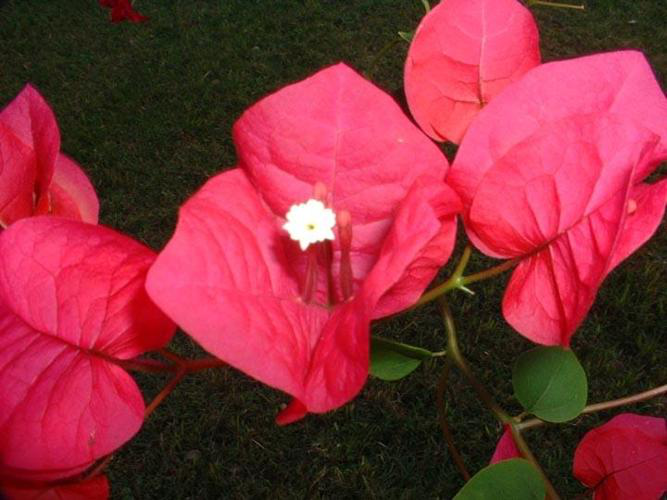

In [45]:
# display the image for reference
img = Image.open(image_path)
img

In [46]:
img.size

(667, 500)

In [47]:
# Process a PIL image for use in a PyTorch model
def process_tensor_image(image_path):
    ''' 
    This function opens the image using the PIL package, 
    Scales, crops, and normalizes a PIL image for a PyTorch model
    Arguments: The image's path
    Returns: The image as a tensor
    '''
    from PIL import Image
    test_image = Image.open(image_path)

    transform_to = transforms.Compose([ # Do the same as the training data we will define a set of
        # transformations that we will apply to the PIL image
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Preprocess the image, transform and make a tensor float
    tensor_image = transform_to(test_image).float()
    # Add an extra batch dimension since pytorch treats all images as batches
    #image.unsqueeze_(0)
    
    return tensor_image     

In [48]:
# the function below converts a PyTorch tensor and displays it in the notebook, This function is provided by Udacity.
def imshow_tensor(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    # image = image.transpose((1, 2, 0))        # use if a tensor is required
    image = image.numpy().transpose((1, 2, 0))  # use if a  np array is required
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1, to prevent noise
    Image = np.clip(image, 0, 1)
    
    plt.title(image_path)
    ax.imshow(image)
    
    return ax

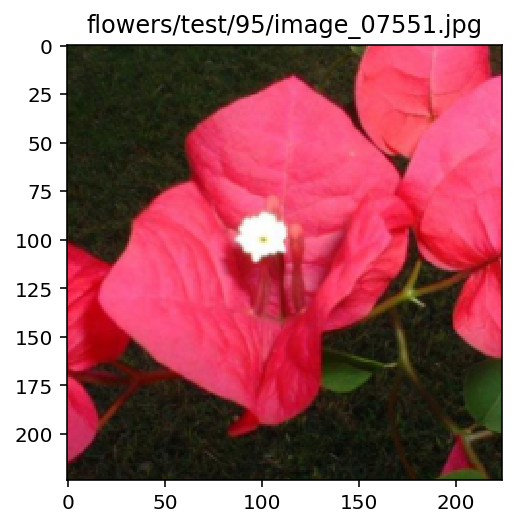

In [49]:
#image_path = 'flowers/train/43/image_02347.jpg'
#show the np array for the chosen image, with image path for flower filename here. 
img = process_tensor_image(image_path)
# Test functions on an example
imshow_tensor(img);

In [50]:
processed_image =  process_tensor_image(image_path)
processed_image.unsqueeze_(0)

tensor([[[[-1.7240, -1.6555, -1.6384,  ..., -1.2103, -1.1418, -1.0219],
          [-1.6384, -1.6042, -1.6384,  ..., -1.0219, -0.9705, -1.0904],
          [-1.5870, -1.6384, -1.5357,  ..., -1.0562, -1.0904, -1.2103],
          ...,
          [-1.6555, -1.5528, -1.5870,  ..., -1.7925, -1.5699, -1.5528],
          [-1.6213, -1.4672, -1.4843,  ..., -1.7925, -1.6042, -1.6042],
          [-1.6555, -1.5185, -1.5528,  ..., -1.7754, -1.6898, -1.6727]],

         [[-1.3704, -1.3354, -1.3704,  ..., -1.2129, -1.1604, -1.0553],
          [-1.3880, -1.3704, -1.4230,  ..., -1.0903, -1.0378, -1.1253],
          [-1.3354, -1.4055, -1.3179,  ..., -1.2304, -1.2304, -1.3179],
          ...,
          [-1.6506, -1.5280, -1.5630,  ..., -1.5980, -1.3529, -1.2829],
          [-1.6331, -1.4755, -1.4930,  ..., -1.6681, -1.4230, -1.3704],
          [-1.6331, -1.5105, -1.5455,  ..., -1.6681, -1.5280, -1.4405]],

         [[-1.5604, -1.5081, -1.5081,  ..., -1.4210, -1.3687, -1.2641],
          [-1.5256, -1.5081, -

In [51]:
# Process a PIL image for use in a PyTorch model
def process_npimage(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    transform = transforms.Compose([
        transforms.Resize(256),      
        transforms.CenterCrop(224), 
        transforms.ToTensor()])
    
    pil_image = Image.open(image)
    pil_image = transform(pil_image).float()
    
    np_image = np.array(pil_image)    
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std    
    np_image = np.transpose(np_image, (2, 0, 1))
            
    return np_image   # return as a np image
    # return torch.from_numpy(np_image)  # return as a tensor image for torch

In [52]:
#image_path = 'flowers/train/43/image_02347.jpg'
#show the np array for the chosen image, with image path for flower filename here. 
np_img = process_npimage(image_path)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

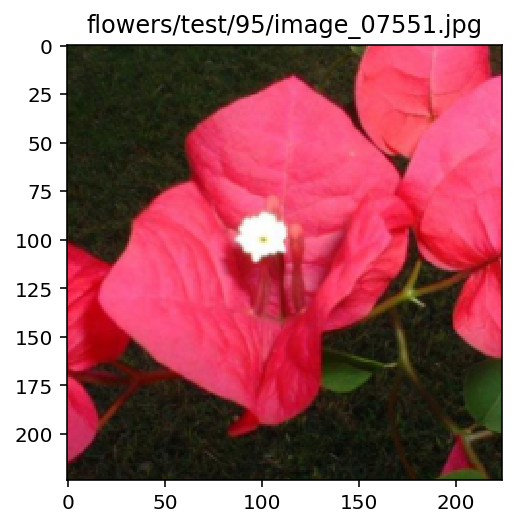

In [53]:
# Test functions on an example
#np_array = process_image(image_path)
#tensor = torch.from_numpy(np_array)
timg = process_tensor_image(image_path)
imshow_tensor(timg)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [55]:
# Get the class ids and Store class_to_idx into a model property
# model.class_to_idx = image_datasets['training_dataset'].classes
model.class_to_idx = image_datasets['training_dataset'].class_to_idx
print(model.class_to_idx)


{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [56]:
# get index to class mapping
idx_to_class = { val : key for key,val in model.class_to_idx.items()}
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [57]:
def predict(image_path, model, topk=5):
    #Predict the class (or classes) of an image using a trained deep learning model.

    model.eval()
    use_gpu = False                               # move model and tensor to device, cpu or cuda
    if torch.cuda.is_available():
        use_gpu = True
        model = model.cuda()
    else:
        model = model.cpu()
        

    np_array = process_npimage(image_path)
    tensor = torch.from_numpy(np_array)
    
    # Run image through model (from either device gpu or cpu) 
    if use_gpu:
        inputs = (tensor.float().cuda())
    else:       
        inputs = tensor.float()            # cnv to float on both gpu and cpu
        
    inputs = inputs.unsqueeze(0)           # unsqueeze the tensor image

    output = model.forward(inputs)         # run tensor through model
    
    # compute the top probabilities, and classes (labels)     
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
    
    # invert the dictionary so you get a mapping from index to class 
    idx_to_class = {model.class_to_idx[k]: k for k in model.class_to_idx}
    top_classes = list()
    for label in classes.numpy()[0]:
        top_classes.append(idx_to_class[label])
        
    top_prob_array = probabilities.numpy()[0]  # get top_probs as numpy array
    return top_prob_array,  top_classes

probs, classes = predict(image_path, model)

print(probs)
print(classes)

[ 0.28900531  0.20937866  0.19313005  0.09297611  0.03762007]
['80', '44', '96', '95', '88']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [60]:
# Display an image along with the top 5 classes
# ref: https://matplotlib.org/gallery/lines_bars_and_markers/barh.html#sphx-glr-gallery-lines-bars-and-markers-barh-py
# https://github.com/sedemmler/AIPND_image_classification/blob/master/Image%20Classifier%20Project.ipynb

def check_sanity(image_path, top_prob_array, classes, cat_to_name): 
    # View an image and it's predicted classes
    
    # Get top prediction
    max_index = np.argmax(probs)
    max_prob = probs[max_index]
    max_label = classes[max_index]

    # Set up flower plot
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), ncols=1, nrows=2)

  
    # Set up title
    flower_name = cat_to_name[max_label] 
    ax1.set_title(flower_name)
    
    # Plot flower 
    img =  Image.open(image_path)
    #img = process_tensor_image(image_path)
    plt.title(flower_name)
    ax1.imshow(img)
    # ax1.axis('off')
    
    # show the probabilty chart, 
    y_pos = np.arange(len(top_prob_array))
    ax2.barh(y_pos, top_prob_array, align='center',color='green')
    ax2.set_yticks(y_pos)   
    ax2.set_yticklabels([cat_to_name[x] for x in classes])   # (flower_names labels, on the y axis
    ax2.invert_yaxis()     # labels read top-to-bottom
    ax2.set_title('Top 5 Class Probabilities')
    ax2.set_xlabel('Probs')
    return

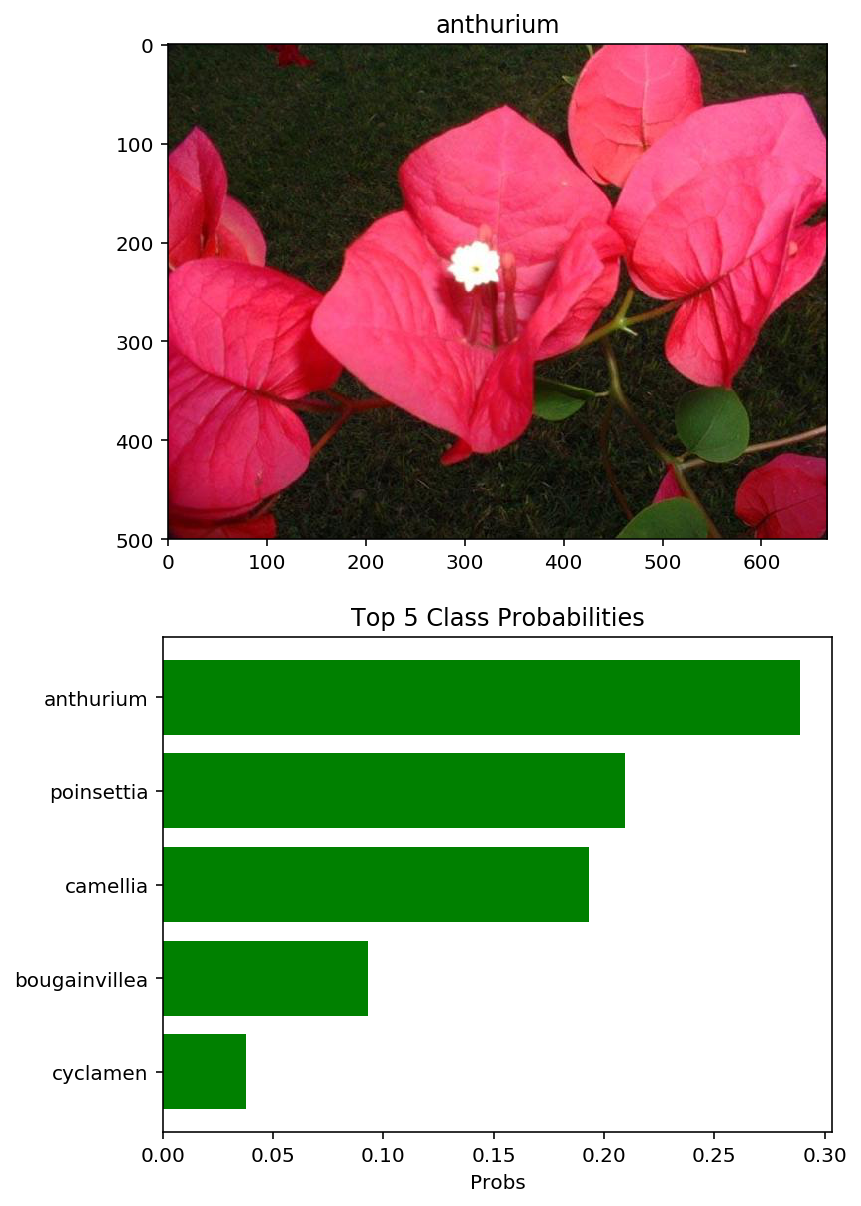

In [61]:
# Make prediction
# Plot the flower and the prediction graph
check_sanity(image_path, probs, classes, cat_to_name)

In [62]:
# !!jupyter nbconvert *.ipynb